In [1]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import (
    fast_filter,
    loglikelihood_sysrem,
    get_rot_kernel,
    fit_uncertainties,
    fit_uncertainties_and_remove_outliers,
)
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt

In [7]:
from POSEIDON.utility import read_high_res_data

data_dir = "./data/WASP-121b-new/"


# These data are both in the rest frame of the star. The blue data are aligned with cross-correlation to stellar lines, and the red data are aligned via cross-correlation with a telluric template (however, in the latter case we also shift/interpolate according to the barycentric and systemic velocities to compensate)
al = np.load("./data/WASP-121b/aligned_C_arrays.npz")
# And the aligned data are stored as:
C_blue, Ce_blue = (
    al["aligned/blue/C"],
    al["aligned/blue/Ce"],
)  # etc, replace blue with redl/redu
C_redl, Ce_redl = (
    al["aligned/redl/C"],
    al["aligned/redl/Ce"],
)  # etc, replace blue with redl/redu
C_redu, Ce_redu = (
    al["aligned/redu/C"],
    al["aligned/redu/Ce"],
)  # etc, replace blue with redl/redu
# And just to be extra confusing, I've already stripped out the 70,71,72 frames. (But not the outer orders)

['aligned/blue/C', 'aligned/blue/Ce', 'aligned/redl/C', 'aligned/redl/Ce', 'aligned/redu/C', 'aligned/redu/Ce']


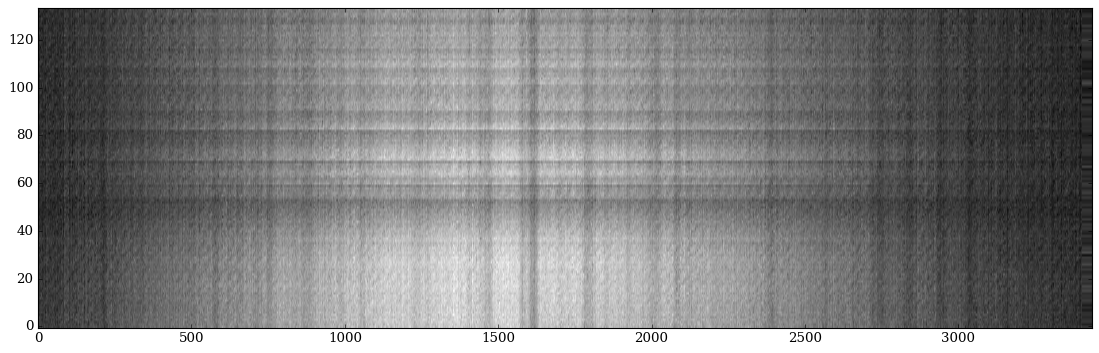

In [40]:
plt.figure(figsize=(17, 5))
plt.imshow(C_redl[15], aspect="auto", origin="lower", cmap="gray")

In [ ]:
# N_order, N_phi, N_wl = C.shape
# simple_model = np.zeros(C.shape)
# residuals = C.copy()
# for i in range(N_order):
#     median_spectrum = np.median(C[i], axis=0).reshape(1, -1)
#     median_lightcurve = np.median(C[i], axis=1).reshape(-1, 1)
#     simple_model[i] = (median_lightcurve @ median_spectrum) / C[i].mean()
#     residuals[i] -= simple_model[i]

In [ ]:
# poly_order = 10
# wl_grid = pickle.load(open("data/wl.pic", "rb"))
# # Fitting a 10th order polynomial to each residual spectrum
# polynomial_fit = np.zeros_like(residuals)
# for i in range(N_order):
#     for j in range(N_phi):
#         coefficients = np.polyfit(wl_grid[i], residuals[i, j], poly_order)
#         polynomial_fit[i, j] = np.polyval(coefficients, wl_grid[i])

# # Replacing outliers by the value of the polynomial fit
# sigma_threshold = 5.0
# outliers_mask = np.abs(residuals - polynomial_fit) > sigma_threshold * np.std(
#     residuals, axis=(1, 2), keepdims=True
# )
# residuals[outliers_mask] = polynomial_fit[outliers_mask]

# # Adding back the simple model for each order
# reconstructed_spectrum = residuals + simple_model

In [37]:
C_redl.shape

(34, 134, 3436)

In [ ]:
# data = reconstructed_spectrum
data = C
data[data < 0] = 0
N_order, N_phi, N_wl = data.shape

In [ ]:
C_norm = np.zeros(data.shape)
for k in range(N_order):
    order = data[k]

    middle = np.median(order, axis=0)
    middle[middle == 0] = np.mean(middle)
    order_norm = order / middle

    C_norm[k] = order_norm

from scipy.ndimage import gaussian_filter1d, median_filter

for det in range(N_order):
    for phi in range(N_phi):
        C_norm[det][phi] = median_filter(C_norm[det][phi], size=501)

for det in range(N_order):
    for phi in range(N_phi):
        C_norm[det][phi] = gaussian_filter1d(C_norm[det][phi], sigma=100)

In [ ]:
data = data / C_norm

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.optimize import minimize


def fit_uncertainties(data_raw, NPC=5):
    uncertainties = np.zeros(data_raw.shape)
    residuals = np.zeros(data_raw.shape)
    N_order = len(data_raw)
    # mask = data_raw == 0
    for i in range(N_order):
        order = data_raw[i]
        svd = TruncatedSVD(n_components=NPC, n_iter=15, random_state=42).fit(order)

        residual = order - (svd.transform(order) @ svd.components_)
        residuals[i] = residual

    for i in range(N_order):

        def fun(x):
            a, b = x
            sigma = np.sqrt(a * data_raw[i] + b)
            loglikelihood = -0.5 * np.sum((residuals[i] / sigma) ** 2) - np.sum(
                np.log(sigma)
            )
            return -loglikelihood

        a, b = minimize(fun, [0.3, 200], method="Nelder-Mead").x
        print(a, b)
        best_fit = np.sqrt(a * data_raw[i] + b)

        svd = TruncatedSVD(n_components=NPC, n_iter=15, random_state=42).fit(best_fit)

        uncertainty = svd.transform(best_fit) @ svd.components_
        uncertainties[i] = uncertainty
    # uncertainties[mask] = 1e7
    return uncertainties

In [32]:
uncertainties = fit_uncertainties(data)

0.39292310783988127 236.1977358900029
0.37732164408340474 260.5269791807312
0.3675470863875575 264.74917837674707
0.39265556002245566 259.3946172397109
0.36440522317899804 267.98862554354696
0.39575482557522845 257.662335605031
0.39826775984933616 259.78897144190773
0.4005394405159153 254.7219322476982
0.37425320573619686 262.04510297258776
0.3564206844488019 267.11580189667495
0.35617445812336834 265.71722310063535
0.35983400817351696 261.3724266146309
0.34204990335678326 269.3678633730831
0.3176044996148196 276.90416906660823
0.33041687272791165 268.87720192968277
0.32908151690584164 268.38829045721025
0.33324637128149515 265.6971573269891
0.30172601864576865 282.747655097658
0.2946059978862453 289.1881064634315
0.29706872627052433 284.11196651079035
0.29957372953176925 281.5403223937409
0.3022034264051191 278.6296416897936
0.2888736062726951 287.9413197735135
0.301308350294366 279.6391444743269
0.3035665173885594 273.26394042671564
0.31432779456452986 265.6320920043671
0.32344005498

In [33]:
wl_grid = pickle.load(open("data/wl.pic", "rb"))

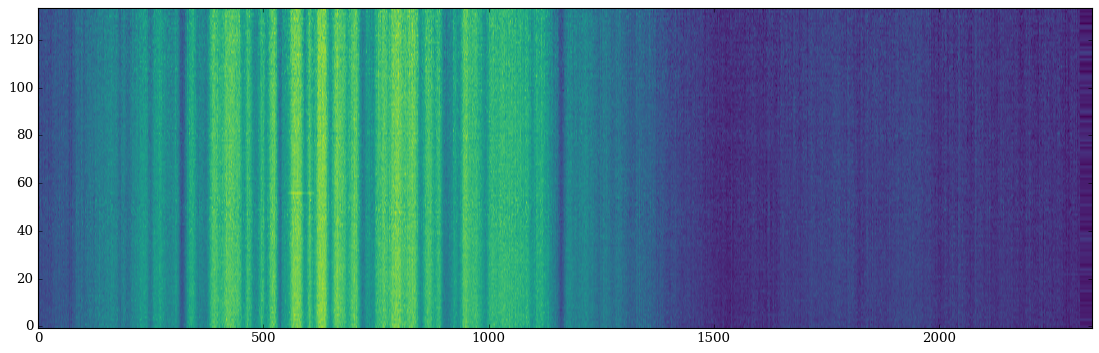

In [34]:
plt.figure(figsize=(17, 5))
plt.imshow(data[6], aspect="auto", origin="lower", cmap="viridis")

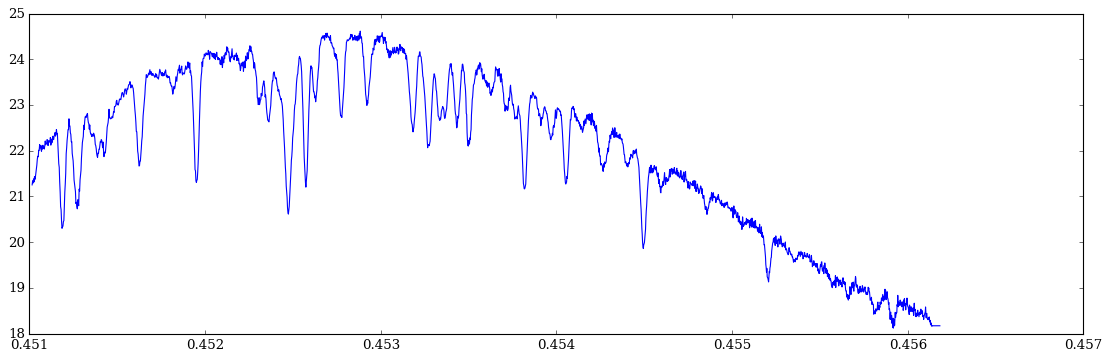

In [35]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[-10], uncertainties[-10, 20])
plt.ticklabel_format(useOffset=False)

In [36]:
def sysrem(data_array, stds, N_iter=15):
    """
    SYSREM procedure adapted from https://github.com/stephtdouglas/PySysRem, originally used for detrending light curves.

    Use this function in a high resolutional rerieval.
    N_order: number of spectral order.
    N_phi: number of time-resolved phases.
    N_wl: number of wavelengths per spectral order.

    Args:
        data_array (2D np.array of float):
            Blaze-corrected data of a single order.
            Shape: (N_phi x N_wl)
        stds (np.array of float):
            Time and wavelength dependent uncertainties obtained from fit_uncertainties.
            Shape: (N_phi x N_wl)
        Niter (int):
            Number of basis vectors to consider.

    Returns:
        residuals (np.array of float):
            2D Array representing the residuals data of a single order after filtering.
            Shape: (N_phi x N_wl)

        U (2D np.array of float):
            Basis vectors obtained from SYSREM of a single vector.
            Shape: (N_phi x N_iter + 1)
    """
    data_transpose = data_array.T
    N_wl, N_phi = data_transpose.shape

    # Create empty matrices for residuals and corresponding errors with the found dimensions such that number of rows correspond to the number of available stars, and the number of columns correspond to each specific epoch:
    residuals = np.zeros((N_wl, N_phi))

    median_list = []
    # Import each of the star files
    for i, wl_channel in enumerate(data_transpose):
        # Calculate residuals from the ORIGINAL light curve
        channel_residual = wl_channel - np.median(wl_channel)
        # channel_residual = wl_channel

        # import the residual and error values into the matrices in the correct position (rows corresponding to stars, columns to epochs)
        residuals[i] = channel_residual

    N_wl, N_phi = np.shape(residuals)

    # This medians.txt file is a 2D list with the first column being the medians
    # of stars' magnitudes at different epochs (the good ones) and their
    # standard deviations, so that they can be plotted against the results after
    # errors are taken out below.

    U = np.zeros((N_phi, N_iter + 1))

    for i in range(N_iter):  # The number of linear systematics to remove
        w = np.zeros(N_wl)
        u = np.ones(N_phi)

        # minimize a and c values for a number of iterations, Niter
        for _ in range(10):
            # Using the initial guesses for each a value of each epoch, minimize c for each star
            for pix in range(N_wl):
                err_squared = stds.T[pix] ** 2
                numerator = np.sum(u * residuals[pix] / err_squared)
                denominator = np.sum(u**2 / err_squared)
                w[pix] = numerator / denominator

            # Using the c values found above, minimize a for each epoch
            for phi in range(N_phi):
                err_squared = stds.T[:, phi] ** 2
                numerator = np.sum(w * residuals[:, phi] / err_squared)
                denominator = np.sum(w**2 / err_squared)
                u[phi] = numerator / denominator

        # Create a matrix for the systematic errors:
        systematic = np.zeros((N_wl, N_phi))
        for pix in range(N_wl):
            for phi in range(N_phi):
                systematic[pix, phi] = u[phi] * w[pix]

        # Remove the systematic error
        residuals = residuals - systematic

        U[:, i] = u

    # for i in range(len(residuals)):
    #     residuals[i] += median_list[i]

    U[:, -1] = np.ones(N_phi)

    return residuals.T, U


def fast_filter(data, uncertainties, N_iter=15):
    """
    TODO: Add docstrings.
    Use this function in a high resolutional rerieval.

    Args:

    Returns:
        residuals (3D np.array of float):
            The residuals data of a single order after filtering.
            Shape: (N_order x N_phi x N_wl)

        Us (3D np.array of float):
            Basis vectors obtained from SYSREM of a single vector.
            Shape: (N_order x N_phi x N_iter+1)
    """
    N_order, N_phi, N_wl = data.shape
    residuals = np.zeros((N_order, N_phi, N_wl))
    Us = np.zeros(
        (N_order, N_phi, N_iter + 1)
    )  # TODO: could turn into np.ones for clarity. This corresponds to Gibson 2021. page 4625.

    for i, order in enumerate(data):
        stds = uncertainties[i]
        residual, U = sysrem(order, stds, N_iter)
        residuals[i] = residual
        Us[i] = U

    return residuals, Us

In [1]:
from POSEIDON.utility import read_high_res_data

In [38]:
from POSEIDON.high_res import fast_filter

for i in range(len(data)):
    order = data[i]
    # out_of_transit_frames = np.concatenate((order[:20], order[-20:]), axis=0)
    median = np.median(order, axis=0)
    median[median == 0] = np.mean(median)
    order_norm = order / median
    uncertainty = uncertainties[i]

    uncertainty_norm = uncertainty / median

    uncertainties[i] = uncertainty_norm
    data[i] = order_norm

residuals, Us = fast_filter(data, uncertainties, N_iter=15)

In [39]:
data_dir = "data/WASP-121b/"
os.makedirs(data_dir, exist_ok=True)
pickle.dump(
    uncertainties,
    open(data_dir + "/uncertainties.pic", "wb"),
)
pickle.dump(
    [wl_grid, data],
    open(data_dir + "/data_raw.pic", "wb"),
)

In [40]:
(N_order, N_phi, N_wl) = data.shape
Bs = np.zeros((N_order, N_phi, N_phi))

for j in range(N_order):
    U = Us[j]
    L = np.diag(1 / np.mean(uncertainties[j], axis=-1))
    B = U @ np.linalg.pinv(L @ U) @ L
    Bs[j] = B

In [ ]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[0], residuals[0][50])
plt.ticklabel_format(useOffset=False)

In [41]:
pickle.dump([Bs, residuals], open(data_dir + "/fast_filter.pic", "wb"))

In [ ]:
residuals.shape

In [ ]:
plt.figure(figsize=(17, 5))
plt.imshow(residuals[10], aspect="auto", origin="lower", cmap="inferno")

In [ ]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[10], uncertainties[10, 30])
plt.ticklabel_format(useOffset=False)

In [ ]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[10], residuals[10, 30])
plt.ticklabel_format(useOffset=False)

In [ ]:
uncertainties[-1]

In [ ]:
data[0][0]

In [ ]:
wl_grid

In [62]:
phi = pickle.load(open("./data/WASP-121b/phi.pic", "rb"))
phi = np.concatenate((phi[:69], phi[72:]))

In [59]:
phi = pickle.load(open("./data/phi.pic", "rb"))
phi[70]

0.003948443843813258

In [64]:
pickle.dump(phi, open("./data/WASP-121b/phi.pic", "wb"))

In [65]:
transit_weight = pickle.load(open("./data/transit_weight.pic", "rb"))
transit_weight = np.concatenate((transit_weight[:69], transit_weight[72:]))

In [68]:
pickle.dump(transit_weight, open("./data/WASP-121b/transit_weight.pic", "wb"))

In [3]:
data = read_high_res_data("./data/WASP-121b/")

In [4]:
data["uncertainties"]

array([[[0.15633712, 0.16034907, 0.1690161 , ..., 0.26773138,
         0.26773228, 0.26773274],
        [0.15538829, 0.16009779, 0.16884967, ..., 0.26918219,
         0.2691831 , 0.26918356],
        [0.15555641, 0.16021886, 0.16845409, ..., 0.26803959,
         0.2680405 , 0.26804095],
        ...,
        [0.15648111, 0.15956367, 0.16842632, ..., 0.27267433,
         0.27267513, 0.27267553],
        [0.15807425, 0.16032287, 0.16837547, ..., 0.25987121,
         0.25987202, 0.25987242],
        [0.1556585 , 0.15896868, 0.16849888, ..., 0.2667919 ,
         0.26679269, 0.26679308]],

       [[0.11648735, 0.11664514, 0.12289399, ..., 0.29542344,
         0.29542338, 0.29542335],
        [0.11561105, 0.11637955, 0.12285815, ..., 0.29556088,
         0.29556082, 0.29556079],
        [0.11574078, 0.11654287, 0.1227975 , ..., 0.2949225 ,
         0.29492244, 0.29492241],
        ...,
        [0.11769225, 0.11605529, 0.12230455, ..., 0.3016304 ,
         0.30163024, 0.30163015],
        [0.1

In [5]:
data["residuals"]

array([[[-0.11852369,  0.02128725,  0.12002103, ..., -0.04108667,
         -0.04108576, -0.04108531],
        [-0.19735188, -0.09495496, -0.0626506 , ...,  0.00608589,
          0.00608172,  0.00607963],
        [ 0.04233753, -0.06638722,  0.01361665, ..., -0.0438605 ,
         -0.04385813, -0.04385695],
        ...,
        [ 0.06035947, -0.00141657,  0.01260642, ..., -0.04092799,
         -0.04092388, -0.04092182],
        [ 0.07600125, -0.14565173,  0.04511631, ...,  0.1637864 ,
          0.16378945,  0.16379097],
        [-0.06237736,  0.01845901,  0.02327808, ...,  0.02887782,
          0.02888316,  0.02888583]],

       [[ 0.10480746,  0.00728437,  0.03408735, ..., -0.00136284,
         -0.00136175, -0.00136121],
        [-0.02861984, -0.14525918, -0.08685166, ..., -0.01767133,
         -0.01767571, -0.0176779 ],
        [ 0.06941716, -0.02119091, -0.05269758, ...,  0.0766732 ,
          0.07666916,  0.07666713],
        ...,
        [ 0.00522078, -0.01076158, -0.04189363, ...,  